In [1036]:
#!/usr/bin/env python
# coding: utf-8
import time
import datetime as dt
from datetime import datetime
from datetime import timedelta
import shlex
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import date2num as d2
import fileinput
import icecream as ic
from matplotlib.ticker import PercentFormatter
import arrow
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
%matplotlib inline

path = r'C:\Users\tsadmin\PycharmProjects\Codewars\Chess_scraping\\'
root = 'ubad00d'
filename = path + root + '.txt'  # This is the path where the final CSV gets created
person_of_interest = 'ubad00d'
UTC_DATE_KEY = '[UTCDate "'
UTC_TIME_KEY = '[UTCTime "'
termination = '[Termination'

In [1037]:
def main():
    Total_games = 0
    with open(path + root + '.pgn', 'r') as infile:

        lines = infile.readlines()

        utc_date = None
        utc_time = None
        utc_endtime = ''

        empty_data = {'time': [],
                      'end_time': [],
                      'result': [],
                      'colour': [],
                      'reason': [],
                      'white_elo': [],
                      'black_elo': []
                      }

        final_data = {'time': [],
                      'end_time': [],
                      'result': [],
                      'colour': [],
                      'reason': [],
                      'white_elo': [],
                      'black_elo': []
                      }

        temp_data = {'time': [],
                     'end_time': [],
                     'result': [],
                     'colour': [],
                     'reason': [],
                     'white_elo': [],
                     'black_elo': []
                     }
        winsby = {'checkmate': 0, 'resignation': 0, 'time': 0, 'abandoned': 0}
        drawsby = {'repetition': 0, 'stalemate': 0, 'agreement': 0, 'insufficient material': 0,
                   'timeout vs insufficient material': 0, '50-move rule': 0}
        lossby = {'checkmate': 0, 'resignation': 0, 'time': 0, 'abandoned': 0}
        win_total = 0
        loss_total = 0
        draw_total = 0

        # Now we're going through all the games line by line (of the PGN format)

        for line in lines:
            fmt = '%Y.%m.%d %H:%M:%S'
            if 'White "ubad00d"' in line:
                temp_data['colour'].append('White')
            if 'Black "ubad00d"' in line:
                temp_data['colour'].append('Black')
            if line.startswith('[WhiteElo "'):
                WHITE_ELO = line[len('[WhiteElo "'):-3]
                temp_data['white_elo'].append(WHITE_ELO)
            if line.startswith('[BlackElo "'):
                BLACK_ELO = line[len('[BlackElo "'):-3]
                temp_data['black_elo'].append(BLACK_ELO)
            if line.startswith(UTC_DATE_KEY):
                utc_date = line[len(UTC_DATE_KEY):-3]
            if line.startswith(UTC_TIME_KEY):
                utc_time = line[len(UTC_TIME_KEY):-3]
                timestamp = datetime.strptime(utc_date + ' ' + utc_time, fmt)
                temp_data['time'].append(timestamp)
            if line.startswith('[EndTime "'):
                utc_endtime = line[len('[EndTime "'):-3]
                end_timestamp = datetime.strptime(utc_date + ' ' + utc_endtime, fmt)
                temp_data['end_time'].append(end_timestamp)
            if ('time_control' in line) and ('time_control=\'600\'' not in line):
                # reinitialise temp_data
                temp_data = {'time': [],
                        'end_time': [],
                        'result': [],
                        'colour': [],
                        'reason': [],
                        'white_elo': [],
                        'black_elo': []
                            }
                continue 
            if ('time_control=\'600\'' in line):
                # save data (temp) to final data, then reinitiliase data (temp)
                if temp_data != empty_data:
                
                    for i in temp_data:
                        final_data[i] = final_data[i] + temp_data[i]

                    temp_data = {'time': [],
                    'end_time': [],
                    'result': [],
                    'colour': [],
                    'reason': [],
                    'white_elo': [],
                    'black_elo': []
                        }
                        
        for line in lines:
            if termination in line:
                if 'Game drawn by' in line:
                    reason_parts = shlex.split(line.strip('[]\n'))[1].split()
                    draw_reason = ' '.join(reason_parts[3:])
                    draw_total += 1
                    temp_data['reason'].append(draw_reason)
                    temp_data['result'].append('draw')
                elif person_of_interest in line:
                    if 'won' in line:
                        reason_parts = shlex.split(line.strip('[]\n'))[1].split()
                        reason = reason_parts[len(reason_parts) - 1]
                        temp_data['reason'].append(reason)
                        temp_data['result'].append('win')
                        win_total += 1
                elif person_of_interest not in line and 'won' in line:
                    reason_parts = shlex.split(line.strip('[]\n'))[1].split()
                    loss_reason = reason_parts[len(reason_parts) - 1]
                    temp_data['reason'].append(loss_reason)
                    temp_data['result'].append('loss')
                    loss_total += 1
            if ('time_control' in line) and ('time_control=\'600\'' not in line):
            # delete temp data
                temp_data = {'time': [],
                            'end_time': [],
                            'result': [],
                            'colour': [],
                            'reason': [],
                            'white_elo': [],
                            'black_elo': []
                            }
                continue 
            if 'time_control=\'600\'' in line:
                # save temp_data to final data, then reinitiliase temp_data
                if temp_data != empty_data:
                    for i in temp_data:
                        final_data[i] = [*final_data[i], *temp_data[i]]

                    temp_data = {'time': [],
                    'end_time': [],
                    'result': [],
                    'colour': [],
                    'reason': [],
                    'white_elo': [],
                    'black_elo': []
                                }

        chess_data = pd.DataFrame(final_data)

        return final_data, chess_data


In [1038]:
final_data, chess_data = main()
chess_data


,time,end_time,result,colour,reason,white_elo,black_elo
0,2019-11-17 22:04:41,2019-11-17 22:08:19,win,Black,abandoned,893,1307
1,2019-11-17 22:12:00,2019-11-17 22:29:06,win,White,time,1353,847
2,2019-11-24 03:20:20,2019-11-24 03:29:54,loss,White,checkmate,1220,1357
3,2019-11-24 13:48:58,2019-11-24 14:05:39,loss,Black,time,1308,1131
4,2019-11-24 19:10:15,2019-11-24 19:20:13,loss,White,checkmate,1046,1122
...,...,...,...,...,...,...,...
2781,2021-09-18 09:18:00,2021-09-18 09:32:34,win,Black,checkmate,1550,1605
2782,2021-09-19 09:30:17,2021-09-19 09:47:36,loss,White,resignation,1598,1674
2783,2021-09-19 09:51:43,2021-09-19 10:08:49,win,Black,resignation,1551,1605
2784,2021-09-21 09:37:22,2021-09-21 09:46:38,loss,Black,resignation,1591,1596


In [1039]:
#converting elo values from str to int.
chess_data[["white_elo", "black_elo"]] = chess_data[["white_elo", "black_elo"]].apply(pd.to_numeric)
# print(type(chess_data.iloc[0,5]))


In [1046]:
#Checking no games are lower or higher elo than they should be
mask = (chess_data['white_elo'] < 300) & (chess_data['white_elo'] > 3000)
chess_data[mask]

,time,end_time,result,colour,reason,white_elo,black_elo


In [1047]:
chess_data['game_length_s'] = chess_data.end_time - chess_data.time
chess_data['game_length_s'] = chess_data['game_length_s'].apply(timedelta.total_seconds)
chess_data['game_length_s'] = chess_data['game_length_s'].apply(int)
chess_data['game_length_m'] = chess_data['game_length_s'].apply(lambda x: round((x / 60), 2))

#we made a game_length (seconds) column by taking difference of start and end times
#We also converted game_length to minutes


In [1048]:
#DATA CLEANING
#get rid of any weird minus game length times that shouldn't be there
chess_data2 = (chess_data['game_length_s'] > 0) & (chess_data['game_length_s'] < 1201)
chess_data = chess_data[chess_data2]

In [1049]:
#We've deleted some rows so let's reset the index count and delete the old index
chess_data.reset_index(inplace=True)
chess_data.drop(['index'], axis=1, inplace=True)


C:\Users\tsadmin\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [1050]:
chess_data['game_id'] = (chess_data.index + 1) # let's put a game count column in that starts from 1

<ipython-input-1050-9c365c3334ba>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chess_data['game_id'] = (chess_data.index + 1) # let's put a game count column in that starts from 1


In [1051]:
chess_data.describe(include='all').transpose()

<ipython-input-1051-4a0611ea152f>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  chess_data.describe(include='all').transpose()
<ipython-input-1051-4a0611ea152f>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  chess_data.describe(include='all').transpose()


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
time,2714,2714,2021-03-24 09:24:13,1,2019-11-17 22:04:41,2021-09-21 09:46:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
end_time,2714,2714,2020-07-31 20:32:27,1,2019-11-17 22:08:19,2021-09-21 10:04:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
result,2714,3,win,1326,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
colour,2714,2,Black,1360,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reason,2714,9,resignation,1487,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
white_elo,2714.0,NaN,NaN,NaN,NaT,NaT,1149.752763,280.84552,389.0,971.0,1078.5,1417.0,1723.0
black_elo,2714.0,NaN,NaN,NaN,NaT,NaT,1146.852616,282.094812,272.0,968.0,1078.0,1416.0,1723.0
game_length_s,2714.0,NaN,NaN,NaN,NaT,NaT,621.858511,311.991711,3.0,367.0,614.0,879.75,1200.0
game_length_m,2714.0,NaN,NaN,NaN,NaT,NaT,10.364307,5.199882,0.05,6.12,10.23,14.665,20.0
game_id,2714.0,NaN,NaN,NaN,NaT,NaT,1357.5,783.60864,1.0,679.25,1357.5,2035.75,2714.0


In [1052]:
chess_data.isnull().sum() #checking there are no null values

time             0
end_time         0
result           0
colour           0
reason           0
white_elo        0
black_elo        0
game_length_s    0
game_length_m    0
game_id          0
dtype: int64

In [1053]:
chess_data.colour.value_counts()

Black    1360
White    1354
Name: colour, dtype: int64

In [1054]:
my_elo_list = []
opponent_elo_list = []

for index, row in chess_data.iterrows():
    if row['colour'] == 'White':
        my_elo_list.append(row['white_elo'])
        opponent_elo_list.append(row['black_elo'])
    else:
        my_elo_list.append(row['black_elo'])
        opponent_elo_list.append(row['white_elo'])
        
my_elo = pd.Series(my_elo_list)
opponent_elo = pd.Series(opponent_elo_list)
chess_data['my_elo'] =  my_elo
chess_data['opponent_elo'] = opponent_elo


<ipython-input-1054-3396cc12bb08>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chess_data['my_elo'] =  my_elo
<ipython-input-1054-3396cc12bb08>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chess_data['opponent_elo'] = opponent_elo


In [1056]:
sample_size = len(chess_data.index) # let's save how many rows there are in case it's useful later
sample_size

2714

In [1057]:
chess_data['elo_difference'] = chess_data['opponent_elo'] - chess_data['my_elo']


<ipython-input-1057-a083fae54d6d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chess_data['elo_difference'] = chess_data['opponent_elo'] - chess_data['my_elo']


In [1058]:
chess_data.groupby('time').time.apply(lambda x: (x.shift(1) - x))

# df.groupby('case')['change'].apply(lambda x: x.shift(-1) - x)

0      NaT
1      NaT
2      NaT
3      NaT
4      NaT
        ..
2709   NaT
2710   NaT
2711   NaT
2712   NaT
2713   NaT
Name: time, Length: 2714, dtype: timedelta64[ns]

In [1198]:
def result_numerical_fn(x):
    if x == 'win':
        return 1
    elif x == 'draw':
        return 0
    elif x == 'loss':
        return -1
    
def colour_numerical_fn(x):
    if x == 'White':
        return 1
    elif x == 'Black':
        return 0

    
    
chess_data['colour_numerical'] = chess_data.colour.apply(colour_numerical_fn)
#represent White = 1, Black = 0

chess_data['result_numerical'] = chess_data.result.apply(result_numerical_fn)
#represent win = 1, draw = 0, loss = -1
                                                    

In [1060]:
def day_fn(x):
    return x.isoweekday()

def month_fn(x):
    return x.month

def month_day_fn(x):
    return x.day

def hour_fn(x):
    return x.hour

def minute_fn(x):
    return x.minute

def second_fn(x):
    return x.second

chess_data['Day'] = chess_data.time.apply(day_fn)
chess_data['Month'] = chess_data.time.apply(month_fn)
chess_data['Day_in_month'] = chess_data.time.apply(month_day_fn)
chess_data['Hour'] = chess_data.time.apply(hour_fn)
chess_data['Minute'] = chess_data.time.apply(minute_fn)
chess_data['Second'] = chess_data.time.apply(second_fn)

<ipython-input-1060-5d1e541eb997>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chess_data['Day'] = chess_data.time.apply(day_fn)
<ipython-input-1060-5d1e541eb997>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chess_data['Month'] = chess_data.time.apply(month_fn)
<ipython-input-1060-5d1e541eb997>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [1061]:
def time_fn(x):
    return dt.time(hour_fn(x), minute_fn(x), second_fn(x))

chess_data['Time'] = chess_data.time.apply(time_fn)


<ipython-input-1061-bee6f0829588>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chess_data['Time'] = chess_data.time.apply(time_fn)


In [1064]:
def daily_game_count():
    #return count of games from this day
    #if current_day == day then add 1 to count
    #if current_day != day before then reset count
    daily_game_count_list = []
    daily_game_count = 0
    previous_day = 1
    for index, row in chess_data.iterrows():
        
        if row['Day'] == previous_day:
            #same day as before
            daily_game_count_list.append(daily_game_count)
            daily_game_count +=1
        elif row['Day'] != previous_day:
            #new day now
            daily_game_count = 0
            daily_game_count_list.append(daily_game_count)
            daily_game_count +=1
            previous_day = row['Day']
            
    Daily_game_count = pd.Series(daily_game_count_list)

    chess_data['daily_game_count'] =  Daily_game_count

    
def daily_result_aggregate():
    #return aggregate of result (1,0,-1) from this day
    daily_result_aggregate_list = []
    daily_result_aggregate = 0
    previous_day = 1
    
    for index, row in chess_data.iterrows():
        
        if row['Day'] == previous_day:
            daily_result_aggregate_list.append(daily_result_aggregate)
            daily_result_aggregate += row['result_numerical']
            #same day as before
            
        elif row['Day'] != previous_day:
            #new day now
            daily_result_aggregate = 0
            daily_result_aggregate_list.append(daily_result_aggregate)
            daily_result_aggregate +=1
            previous_day = row['Day']
            
    Daily_result_aggregate = pd.Series(daily_result_aggregate_list)

    chess_data['daily_result_aggregate'] =  Daily_result_aggregate
    
def time_since_last_game():
    #return time(n) - time(n-1)
    time_since_last_game_list = []
    time_since_last_game = 0
    previous_time = 0
    for index, row in chess_data.iterrows():
        if previous_time == 0:
            time_since_last_game = row['time']
            time_since_last_game_list.append(time_since_last_game)
            previous_time = row['time']
        else:
            time_since_last_game = row['time'] - previous_time
            time_since_last_game_list.append(time_since_last_game)
            previous_time = row['time']
    Time_since_last_game = pd.Series(time_since_last_game_list)
    chess_data['time_since_last_game'] = Time_since_last_game
    
    
daily_game_count()
daily_result_aggregate()
time_since_last_game()

<ipython-input-1064-e149ed4c4f2f>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chess_data['daily_game_count'] =  Daily_game_count
<ipython-input-1064-e149ed4c4f2f>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chess_data['daily_result_aggregate'] =  Daily_result_aggregate
<ipython-input-1064-e149ed4c4f2f>:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

In [1065]:
def last_game_result():
    #return result of last game
    #chess_data['last_game_result']
    previous_result_list = []
    previous_result_numerical = 0
    
    for index, row in chess_data.iterrows():
        previous_result_list.append(previous_result_numerical)
        previous_result_numerical = row['result_numerical']
    
    Previous_result = pd.Series(previous_result_list)
    chess_data['Previous_result'] =  Previous_result
    
last_game_result()

<ipython-input-1065-69dddfbfb1ee>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chess_data['Previous_result'] =  Previous_result


In [1066]:
def length_of_last_game():
    #return length of last
    length_of_last_game_list = []
    length_of_last_game = 10
    
    for index, row in chess_data.iterrows():
        length_of_last_game_list.append(length_of_last_game)
        length_of_last_game = row['game_length_m']
    Length_of_last_game = pd.Series(length_of_last_game_list)
    chess_data['length_of_last_game'] = Length_of_last_game


length_of_last_game()

<ipython-input-1066-2abc4c0c3aa4>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chess_data['length_of_last_game'] = Length_of_last_game


In [1067]:
chess_data_first_row_temp = chess_data[0:1]


In [1068]:
chess_data = chess_data.iloc[1: , :]
chess_data['time_since_last_game_m'] = chess_data['time_since_last_game'].apply(timedelta.total_seconds)
chess_data['time_since_last_game_m'] = chess_data['time_since_last_game_m'].apply(int)
chess_data['time_since_last_game_m'] = chess_data['time_since_last_game_m'].apply(lambda x: round((x / (60)), 2))

In [1069]:
#concatenating 
chess_data = pd.concat([chess_data_first_row_temp, chess_data])

In [1070]:
#impute first row of time_since_last_game_m with mean to avoid null. DON'T REPEAT THIS STEP AS MEAN WILL CHANGE EACH TIME
chess_data.time_since_last_game_m[0] = chess_data.time_since_last_game_m.mean()

<ipython-input-1070-1475d0dd293e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chess_data.time_since_last_game_m[0] = chess_data.time_since_last_game_m.mean()


In [1071]:
chess_data['time_since_last_game_m'] = chess_data['time_since_last_game_m'].apply(lambda x: round(x, 2))

In [1072]:
chess_data = chess_data.drop(columns='time_since_last_game')

In [1073]:
#Trigger factor is the result of last game * 1/time_since_last_game, so it takes into account how fresh the win/loss is.
chess_data['trigger_factor'] = (1 / chess_data.time_since_last_game_m) * chess_data.Previous_result

In [1146]:
##########
#ANALYSIS#
##########
chess_data

,time,end_time,result,colour,reason,white_elo,black_elo,game_length_s,game_length_m,game_id,...,Hour,Minute,Second,Time,daily_game_count,daily_result_aggregate,Previous_result,length_of_last_game,time_since_last_game_m,trigger_factor
0,2019-11-17 22:04:41,2019-11-17 22:08:19,win,Black,abandoned,893,1307,218,3.63,1,...,22,4,41,22:04:41,0,0,0,10.00,357.47,0.000000
1,2019-11-17 22:12:00,2019-11-17 22:29:06,win,White,time,1353,847,1026,17.10,2,...,22,12,0,22:12:00,1,1,1,3.63,7.32,0.136612
2,2019-11-24 03:20:20,2019-11-24 03:29:54,loss,White,checkmate,1220,1357,574,9.57,3,...,3,20,20,03:20:20,2,2,1,17.10,8948.33,0.000112
3,2019-11-24 13:48:58,2019-11-24 14:05:39,loss,Black,time,1308,1131,1001,16.68,4,...,13,48,58,13:48:58,3,1,-1,9.57,628.63,-0.001591
4,2019-11-24 19:10:15,2019-11-24 19:20:13,loss,White,checkmate,1046,1122,598,9.97,5,...,19,10,15,19:10:15,4,0,-1,16.68,321.28,-0.003113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2709,2021-09-18 09:18:00,2021-09-18 09:32:34,win,Black,checkmate,1550,1605,874,14.57,2710,...,9,18,0,09:18:00,0,0,1,9.97,5439.22,0.000184
2710,2021-09-19 09:30:17,2021-09-19 09:47:36,loss,White,resignation,1598,1674,1039,17.32,2711,...,9,30,17,09:30:17,0,0,1,14.57,1452.28,0.000689
2711,2021-09-19 09:51:43,2021-09-19 10:08:49,win,Black,resignation,1551,1605,1026,17.10,2712,...,9,51,43,09:51:43,1,1,-1,17.32,21.43,-0.046664
2712,2021-09-21 09:37:22,2021-09-21 09:46:38,loss,Black,resignation,1591,1596,556,9.27,2713,...,9,37,22,09:37:22,0,0,1,17.10,2865.65,0.000349


In [1195]:
last = chess_data.time.iloc[-2:-1]
first = chess_data.time.iloc[0]
difference = last - first
int(difference.values)
difference = int(difference.values) / (10 ** 9)
total_month_difference = round((((difference / 60) / 60) / 24) / 365 * 12)
total_day_difference = round((((difference / 60) / 60) / 24))

In [1196]:
average_game_length = chess_data.game_length_m.mean()
average_time_since_last_game = chess_data.time_since_last_game_m.mean()
average_games_per_day = chess_data.game_id.count() / total_day_difference
average_total_time_playing_per_day =  average_games_per_day * chess_data.game_length_m.mean()
ic.ic(average_game_length)
ic.ic(average_time_since_last_game)
ic.ic(average_games_per_day)
ic.ic(average_total_time_playing_per_day)

ic| average_game_length: 10.3643072955048
ic| average_time_since_last_game: 357.47224392041346
ic| average_games_per_day: 4.0326894502228825
ic| average_total_time_playing_per_day: 41.79603268945026


41.79603268945026

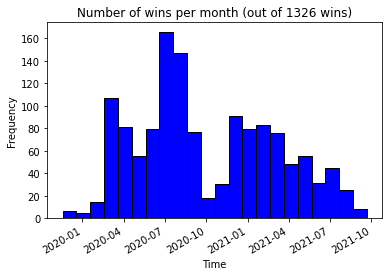

In [1149]:
#plot distribution of wins across time as histogram
chess_data_win = chess_data[chess_data['result'] == 'win']
sample_size_win = len(chess_data_win.index)

plt.hist(chess_data_win['time'], color = 'blue', edgecolor = 'black', bins = total_month_difference)
plt.title(f'Number of wins per month (out of {sample_size_win} wins)')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.gcf().autofmt_xdate() #make X axis look better with dates
plt.show;

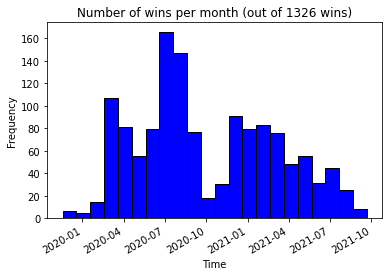

In [1150]:
#Win rate per month

chess_data_win = chess_data[chess_data['result'] == 'win']
sample_size_win = len(chess_data_win.index)

plt.hist(chess_data_win['time'], color = 'blue', edgecolor = 'black', bins = total_month_difference)
plt.title(f'Number of wins per month (out of {sample_size_win} wins)')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.gcf().autofmt_xdate() #make X axis look better with dates
plt.show;

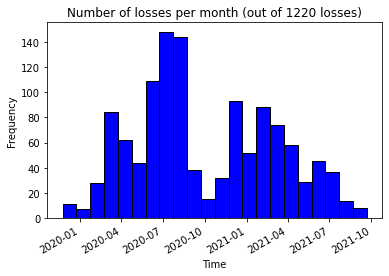

In [1151]:
#plot distribution of losses across time as histogram
chess_data_loss = chess_data[chess_data['result'] == 'loss']
sample_size_loss = len(chess_data_loss.index)

plt.hist(chess_data_loss['time'], color = 'blue', edgecolor = 'black', bins = total_month_difference)
plt.title(f'Number of losses per month (out of {sample_size_loss} losses)')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.gcf().autofmt_xdate() #make X axis look better with dates
plt.show;

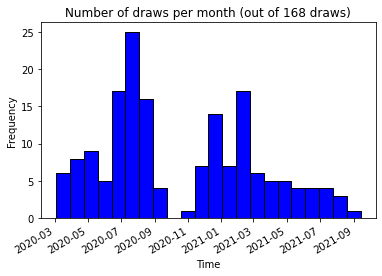

In [1152]:
#plot distribution of draws across time as histogram
chess_data_draw = chess_data[chess_data['result'] == 'draw']
sample_size_draw = len(chess_data_draw.index)

plt.hist(chess_data_draw['time'], color = 'blue', edgecolor = 'black', bins = total_month_difference)
plt.title(f'Number of draws per month (out of {sample_size_draw} draws)')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.gcf().autofmt_xdate() #make X axis look better with dates
plt.show;

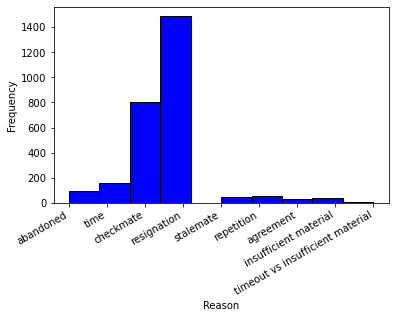

In [1153]:
#plot bar chart of number of reasons for win/loss

plt.hist(chess_data['reason'], color = 'blue', edgecolor = 'black')

plt.xlabel('Reason')
plt.ylabel('Frequency')
plt.gcf().autofmt_xdate()

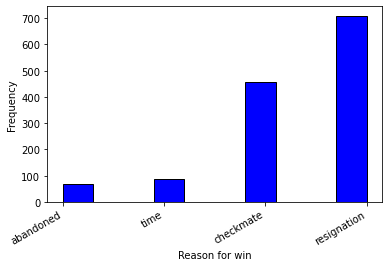

In [1154]:
plt.hist(chess_data_win['reason'], color = 'blue', edgecolor = 'black')

plt.xlabel('Reason for win')
plt.ylabel('Frequency')
plt.gcf().autofmt_xdate()

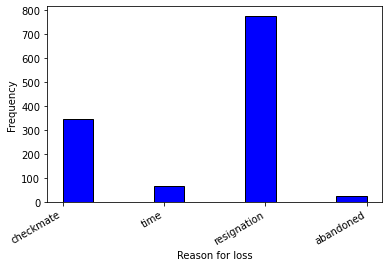

In [1155]:
plt.hist(chess_data_loss['reason'], color = 'blue', edgecolor = 'black')

plt.xlabel('Reason for loss')
plt.ylabel('Frequency')
plt.gcf().autofmt_xdate()

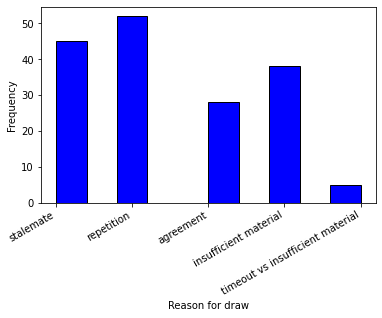

In [1156]:
plt.hist(chess_data_draw['reason'], color = 'blue', edgecolor = 'black')

plt.xlabel('Reason for draw')
plt.ylabel('Frequency')
plt.gcf().autofmt_xdate()

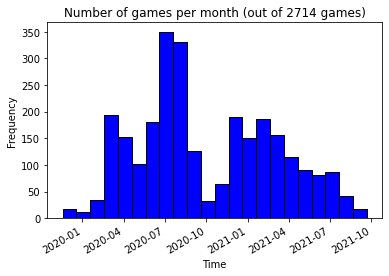

In [1157]:
#plot distribution of games across time as histogram

sample_size = len(chess_data.index)

plt.hist(chess_data['time'], color = 'blue', edgecolor = 'black', bins = total_month_difference)
plt.title(f'Number of games per month (out of {sample_size} games)')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.gcf().autofmt_xdate() #make X axis look better with dates
plt.show;

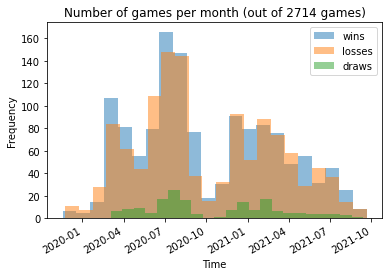

In [1158]:
# Wins/loss/draws on one histograms
plt.hist(chess_data_win['time'], alpha=0.5, label='wins', bins = total_month_difference)
plt.hist(chess_data_loss['time'], alpha=0.5, label='losses', bins = total_month_difference )
plt.hist(chess_data_draw['time'], alpha=0.5, label = 'draws', bins = total_month_difference)
plt.title(f'Number of games per month (out of {sample_size} games)')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.gcf().autofmt_xdate()
plt.show();

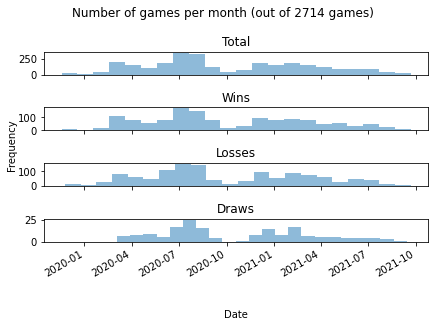

In [1159]:
# # Wins/loss/draws using subplots

fig, axs = plt.subplots(4, sharex=True)

axs[0].hist(chess_data['time'], alpha=0.5, label='Games', bins = total_month_difference)
axs[1].hist(chess_data_win['time'], alpha=0.5, label='wins', bins = total_month_difference)
axs[2].hist(chess_data_loss['time'], alpha=0.5, label='losses', bins = total_month_difference)
axs[3].hist(chess_data_draw['time'], alpha=0.5, label = 'draws', bins = total_month_difference)

plt.suptitle(f'Number of games per month (out of {sample_size} games)')

axs[0].set_title('Total')
axs[1].set_title('Wins')
axs[2].set_title('Losses')
axs[3].set_title('Draws')

plt.gcf().autofmt_xdate()
fig.tight_layout()
fig.text(0.53, -0.1, 'Date', ha='center')
fig.text(0.00, 0.5, 'Frequency', va='center', rotation='vertical')
plt.show();

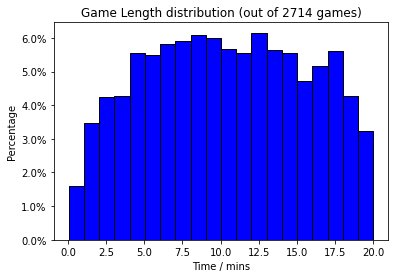

In [1160]:
#plot distribution of game lengths
histogram = plt.hist(chess_data['game_length_m'], weights=np.ones(chess_data.game_length_m.count()) / chess_data.game_length_m.count(), color = 'blue', edgecolor = 'black', bins = 20)

plt.title(f'Game Length distribution (out of {sample_size} games)')
plt.xlabel('Time / mins')
plt.ylabel('Percentage')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1));

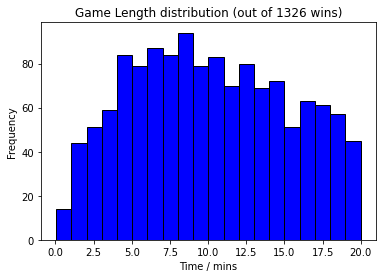

In [1161]:
#plot histogram of game length distribution for WINS only

chess_data_win = chess_data[chess_data['result'] == 'win'] # dataframe only with win rows included
sample_size_wins = len(chess_data_win.index)


histogram = plt.hist(chess_data_win['game_length_m'], color = 'blue', edgecolor = 'black', bins = 20)

plt.title(f'Game Length distribution (out of {sample_size_wins} wins)')
plt.xlabel('Time / mins')
plt.ylabel('Frequency')
plt.show;

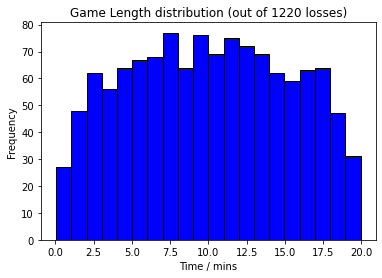

In [1162]:
#plot histogram of game length distribution for LOSSES only

chess_data_loss = chess_data[chess_data['result'] == 'loss'] # dataframe only with win rows included
sample_size_loss = len(chess_data_loss.index)

histogram = plt.hist(chess_data_loss['game_length_m'], color = 'blue', edgecolor = 'black', bins = 20)

plt.title(f'Game Length distribution (out of {sample_size_loss} losses)')
plt.xlabel('Time / mins')
plt.ylabel('Frequency')
plt.show;

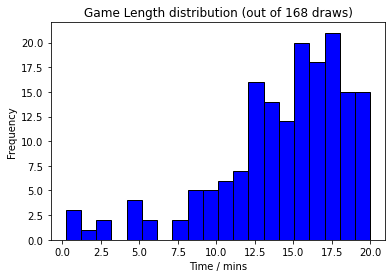

In [1163]:
#plot histogram of game length distribution for DRAWS only

chess_data_draw = chess_data[chess_data['result'] == 'draw'] # dataframe only with win rows included
sample_size_draw = len(chess_data_draw.index)

histogram = plt.hist(chess_data_draw['game_length_m'], color = 'blue', edgecolor = 'black', bins = 20)

plt.title(f'Game Length distribution (out of {sample_size_draw} draws)')
plt.xlabel('Time / mins')
plt.ylabel('Frequency')
plt.show;

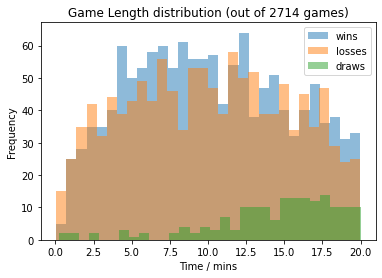

In [1164]:
# Wins/loss/draws on one histograms

plt.hist(chess_data_win['game_length_m'], alpha=0.5, label='wins', bins = 30)
plt.hist(chess_data_loss['game_length_m'], alpha=0.5, label='losses', bins = 30 )
plt.hist(chess_data_draw['game_length_m'], alpha=0.5, label = 'draws', bins = 30)
plt.title(f'Game Length distribution (out of {sample_size} games)')
plt.xlabel('Time / mins')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show();

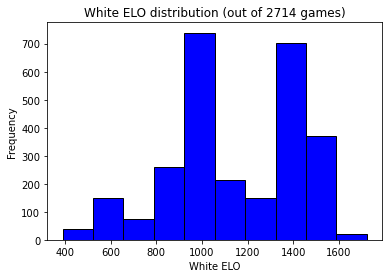

In [1165]:
#plot distribution of white_elo

graph = plt.hist(chess_data['white_elo'], color = 'blue', edgecolor = 'black', bins = 10)
plt.title(f'White ELO distribution (out of {sample_size} games)')
plt.xlabel('White ELO')
plt.ylabel('Frequency')
plt.gcf()
plt.show;

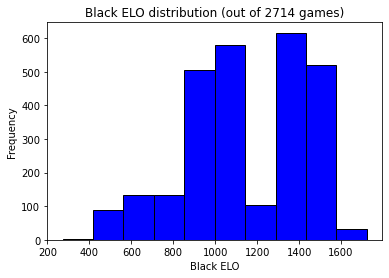

In [1166]:
#plot distribution of black_elo

graph = plt.hist(chess_data['black_elo'], color = 'blue', edgecolor = 'black', bins = 10)
plt.title(f'Black ELO distribution (out of {sample_size} games)')
plt.xlabel('Black ELO')
plt.ylabel('Frequency')
plt.gcf()
plt.show;

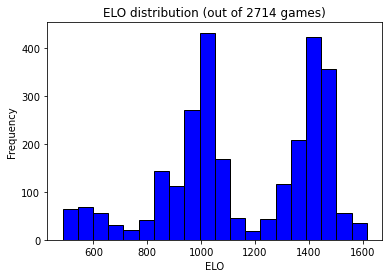

In [1167]:
#plot distribution of my ELO

graph = plt.hist(chess_data['my_elo'], color = 'blue', edgecolor = 'black', bins = 20)
plt.title(f'ELO distribution (out of {sample_size} games)')
plt.xlabel('ELO')
plt.ylabel('Frequency')
plt.show;

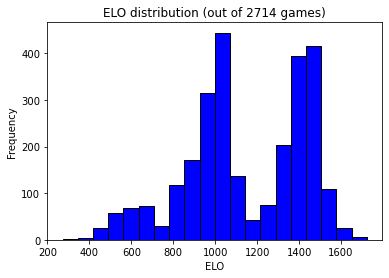

In [1169]:
#plot distribution of opponent's elo

graph = plt.hist(chess_data['opponent_elo'], color = 'blue', edgecolor = 'black', bins = 20)
plt.title(f'ELO distribution (out of {sample_size} games)')
plt.xlabel('ELO')
plt.ylabel('Frequency')
plt.show;

In [ ]:
#plot game length barchart/boxplot vs day of week

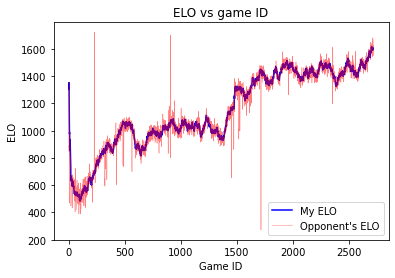

In [1170]:
#my_elo/opponent elo vs game_id

plt.plot(chess_data['game_id'], chess_data['my_elo'], label='My ELO', color = 'blue')
plt.plot(chess_data['game_id'], chess_data['opponent_elo'],linewidth=0.5,alpha=0.5,label='Opponent\'s ELO',color = 'red')

plt.xlabel('Game ID')
plt.ylabel('ELO')

plt.title('ELO vs game ID')
plt.legend(loc='lower right')
plt.show;

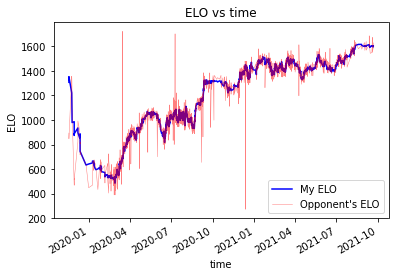

In [1172]:
#my elo/opponent elo vs time

plt.plot(chess_data['time'], chess_data['my_elo'], label='My ELO', color = 'blue')
plt.plot(chess_data['time'], chess_data['opponent_elo'],linewidth=0.5,alpha=0.5,label='Opponent\'s ELO',color = 'red')

plt.xlabel('time')
plt.ylabel('ELO')
plt.gcf().autofmt_xdate()

plt.title('ELO vs time')
plt.legend(loc='lower right')

plt.show;

<function matplotlib.pyplot.show(close=None, block=None)>

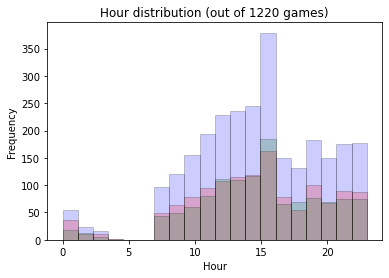

In [1173]:
#plot number of games vs hour in the day

graph = plt.hist(chess_data['Hour'], color = 'blue', edgecolor = 'black', bins = 20, alpha=0.2)
plt.title(f'Hour distribution (out of {sample_size} games)')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.show

#plot number of wins vs hour in the day

graph2 = plt.hist(chess_data_win['Hour'], color = 'red', edgecolor = 'black', bins = 20, alpha=0.2)
plt.title(f'Hour distribution (out of {sample_size_win} games)')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.show

#plot number of losses vs hour in the day

graph3 = plt.hist(chess_data_loss['Hour'], color = 'green', edgecolor = 'black', bins = 20, alpha=0.2)
plt.title(f'Hour distribution (out of {sample_size_loss} games)')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.show

In [ ]:
#Win rate vs hour of day

ConversionError: Failed to convert value(s) to axis units: array([datetime.time(22, 4, 41), datetime.time(22, 12),
       datetime.time(3, 20, 20), ..., datetime.time(9, 51, 43),
       datetime.time(9, 37, 22), datetime.time(9, 46, 50)], dtype=object)

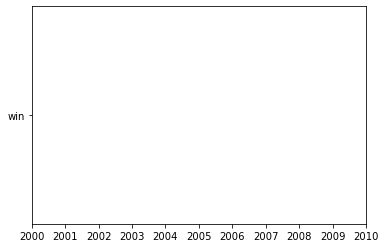

In [1176]:
# #Games over time

# graph = plt.plot_date(chess_data['Time'], chess_data['result'], color = 'blue')
# plt.title(f'Hour distribution (out of {sample_size} games)')
# plt.xlabel('Hour')
# plt.ylabel('Frequency')
# plt.show;

In [ ]:
#plot win rate over time
#win rate = % of games which were my win




In [ ]:
#plot win rate over time for white

In [ ]:
#plot win rate over time for black

In [ ]:
#plot win rate for each hour of day (histogram?)


In [ ]:
#plot win rate for black vs white

Text(0, 0.5, 'White elo')

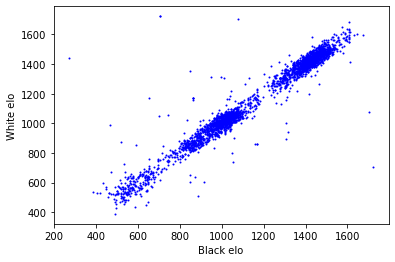

In [1177]:
#plot black elo vs white elo

graph = plt.plot(chess_data['black_elo'], chess_data['white_elo'], '.', markersize=2, color = 'blue')

plt.xlabel('Black elo')
plt.ylabel('White elo')

In [ ]:
#plot win rate for each day of the week (bar chart?)

Text(0, 0.5, 'Opponent elo')

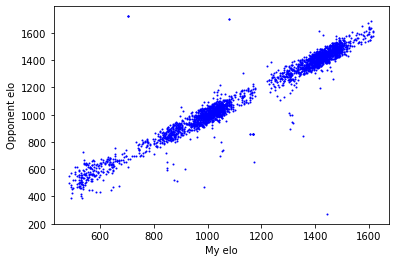

In [1178]:
#plot my elo vs opponent elo

graph = plt.plot(chess_data['my_elo'], chess_data['opponent_elo'], '.', markersize=2, color = 'blue')

plt.xlabel('My elo')
plt.ylabel('Opponent elo')

In [ ]:
-----------------

#MACHINE LEARNING

-----------------

In [1179]:
X = chess_data[['black_elo']]
y = chess_data.white_elo

In [1180]:
lr = LinearRegression()
lr.fit(X,y)

LinearRegression()

In [1181]:
ic.ic(lr.intercept_)
ic.ic(lr.coef_)

ic| lr.intercept_: 41.09458580960518
ic| lr.coef_: array([0.9666963])


array([0.9666963])

In [839]:
new_values = [[800], [1600], [1700], [200], [2000]]
lr.predict(new_values)

array([ 949.19583194, 1566.02949917, 1643.13370758,  486.57058151,
       1874.44633279])

In [1182]:
lr.score(X,y) # returns R^2. Best possible score is 1.0

0.9428341561342357

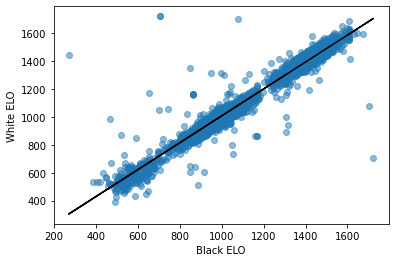

In [1183]:
plt.scatter(X, y, linewidths=1, alpha=0.5)
plt.xlabel('Black ELO')
plt.ylabel('White ELO')
plt.plot(X, lr.predict(X), color='k')

In [ ]:
# The steps to building and using a model are:

# Define: What type of model will it be? A decision tree? Some other type of model? 
# Some other parameters of the model type are specified too. I think this will be logistic regression or decision tree

# Fit: Capture patterns from provided data. This is the heart of modeling.

# Predict: Just what it sounds like

# Evaluate: Determine how accurate the model's predictions are.

In [1184]:
y_ = chess_data.result_numerical
features = ['elo_difference', 'game_length_m', 'colour_numerical', 'Hour', 'Day', 'Day_in_month', 'game_id', 'daily_game_count', 'daily_result_aggregate', 'time_since_last_game_m', 'Previous_result', 'trigger_factor','time_since_last_game_m']
#Would like to add 'last_game_result', and 'cumulative_result_that_day'
X_ = chess_data[features]


In [1185]:
train_X, val_X, train_y, val_y = train_test_split(X_, y_)

In [1186]:
chess_model = DecisionTreeRegressor()
chess_model.fit(train_X,train_y)

DecisionTreeRegressor()

In [397]:
# made_up_data = pd.DataFrame({'elo_difference': [1000, -1000,-100, 0, 0, 100, 2000, -2000], 'game_length_m': [10,10,10,10,10,10,10,10], 'colour_numerical': [1,1,1,0,1,1,1,1]})
# made_up_data

,elo_difference,game_length_m,colour_numerical
0,1000,10,1
1,-1000,10,1
2,-100,10,1
3,0,10,0
4,0,10,1
5,100,10,1
6,2000,10,1
7,-2000,10,1


In [590]:
# input_predictions = chess_model.predict(made_up_data)
# input_predictions

ValueError: X has 4 features, but DecisionTreeRegressor is expecting 6 features as input.

In [399]:
# made_up_data['predicted_result'] = input_predictions
# made_up_data
# Where result = 1 (win), 0 (draw), -1 (loss)
# Positive elo_difference indicates opponent has higher elo

,elo_difference,game_length_m,colour_numerical,predicted_result
0,1000,10,1,-1.0
1,-1000,10,1,1.0
2,-100,10,1,1.0
3,0,10,0,1.0
4,0,10,1,-1.0
5,100,10,1,-1.0
6,2000,10,1,-1.0
7,-2000,10,1,1.0


In [1187]:
val_predictions = chess_model.predict(val_X)

In [1188]:
validation_table = pd.DataFrame(val_y)
validation_table['result_predictions'] = val_predictions
validation_table.result_predictions = validation_table.result_predictions.apply(int)
validation_table.reset_index()
validation_table['Prediction_correct'] = validation_table.result_numerical == validation_table.result_predictions
print(validation_table.Prediction_correct.value_counts())
print(validation_table['result_numerical'].value_counts())
print(validation_table['result_predictions'].value_counts())

validation_table

#Predicted 137 correct and 72 incorrect, not bad. 

True     397
False    282
Name: Prediction_correct, dtype: int64
 1    339
-1    296
 0     44
Name: result_numerical, dtype: int64
 1    343
-1    288
 0     48
Name: result_predictions, dtype: int64


,result_numerical,result_predictions,Prediction_correct
716,0,-1,False
712,-1,-1,True
254,-1,1,False
364,-1,0,False
2595,1,-1,False
...,...,...,...
1334,-1,-1,True
628,-1,-1,True
241,1,1,True
2393,1,1,True


In [1189]:

vtwl = validation_table[validation_table['result_numerical'] == 1].count()[1] # validation table win length
mask_w = ((validation_table['result_numerical'] == 1) & (validation_table['Prediction_correct'] == True))
cwc = validation_table[mask_w].sum()[0] #correct win count

print('rate of correct win prediction:', cwc/vtwl)

vtll = validation_table[validation_table['result_numerical'] == -1].count()[1] # validation table win length
mask_l = ((validation_table['result_numerical'] == -1) & (validation_table['Prediction_correct'] == True))
clc = validation_table[mask_l].sum()[1] #correct win count

print('rate of correct loss prediction:', -clc/vtll)

vtdl = validation_table[validation_table['result_numerical'] == 0].count()[1] # validation table draw length
mask_d = ((validation_table['result_numerical'] == 0) & (validation_table['Prediction_correct'] == True))
cdc = validation_table[mask_d].sum()[2] #correct draw count

print('rate of correct draw prediction:', cdc/vtdl)




rate of correct win prediction: 0.6607669616519174
rate of correct loss prediction: 0.5675675675675675
rate of correct draw prediction: 0.11363636363636363


In [1190]:
mean_absolute_error(val_y, val_predictions)
#adding in daily_game_count and daily_result_aggregate decreases error from 0.77 to 0.67


0.7098674521354934

In [1191]:
importance = chess_model.feature_importances_
importance
#importance of each feature

array([0.3895274 , 0.12201175, 0.01238543, 0.04214782, 0.03202751,
       0.05643122, 0.08489218, 0.05488274, 0.03420943, 0.04673997,
       0.00621102, 0.07071993, 0.0478136 ])

,white_elo,black_elo,game_length_s,game_length_m,game_id,my_elo,opponent_elo,elo_difference,colour_numerical,result_numerical,...,Day_in_month,Hour,Minute,Second,daily_game_count,daily_result_aggregate,Previous_result,length_of_last_game,time_since_last_game_m,trigger_factor
white_elo,1.000000,0.970996,0.139708,0.139711,0.923882,0.986281,0.984767,0.068451,-0.006095,-0.031069,...,-0.111295,0.023764,-0.017049,0.003203,-0.193034,-0.027355,0.012222,0.141270,0.035013,0.002390
black_elo,0.970996,1.000000,0.140454,0.140457,0.924021,0.984556,0.986589,0.083193,-0.020472,-0.030502,...,-0.106791,0.026450,-0.015888,-0.002443,-0.190405,-0.028237,0.006878,0.145509,0.033311,0.005395
game_length_s,0.139708,0.140454,1.000000,1.000000,0.121061,0.143103,0.137130,-0.014191,-0.014915,0.007585,...,-0.029299,0.012429,-0.037166,-0.010503,-0.099333,0.021748,0.027265,0.088838,0.039790,0.022806
game_length_m,0.139711,0.140457,1.000000,1.000000,0.121059,0.143106,0.137133,-0.014187,-0.014920,0.007582,...,-0.029289,0.012433,-0.037171,-0.010510,-0.099342,0.021739,0.027269,0.088843,0.039802,0.022786
game_id,0.923882,0.924021,0.121061,0.121059,1.000000,0.933751,0.914424,-0.010216,-0.014543,-0.001286,...,-0.116256,-0.047918,-0.021901,-0.002518,-0.186702,-0.029499,-0.001894,0.120214,0.029589,0.002649
my_elo,0.986281,0.984556,0.143103,0.143106,0.933751,1.000000,0.971199,-0.044912,-0.008206,0.012139,...,-0.104209,0.025360,-0.019240,0.001670,-0.194361,-0.030503,0.012513,0.142482,0.037583,0.004708
opponent_elo,0.984767,0.986589,0.137130,0.137133,0.914424,0.971199,1.000000,0.194412,-0.018302,-0.072935,...,-0.113791,0.024866,-0.013746,-0.000900,-0.189140,-0.025144,0.006630,0.144305,0.030803,0.003099
elo_difference,0.068451,0.083193,-0.014191,-0.014187,-0.010216,-0.044912,0.194412,1.000000,-0.042951,-0.355765,...,-0.048075,-0.000146,0.021576,-0.010649,0.007151,0.020155,-0.023715,0.018452,-0.025573,-0.006388
colour_numerical,-0.006095,-0.020472,-0.014915,-0.014920,-0.014543,-0.008206,-0.018302,-0.042951,1.000000,0.087658,...,0.001795,-0.002320,-0.015723,0.041532,0.009397,-0.002469,0.005800,0.002175,-0.010237,0.004004
result_numerical,-0.031069,-0.030502,0.007585,0.007582,-0.001286,0.012139,-0.072935,-0.355765,0.087658,1.000000,...,0.043283,-0.025103,-0.046956,0.014032,0.008589,0.025251,0.029078,0.011179,-0.012209,0.055494


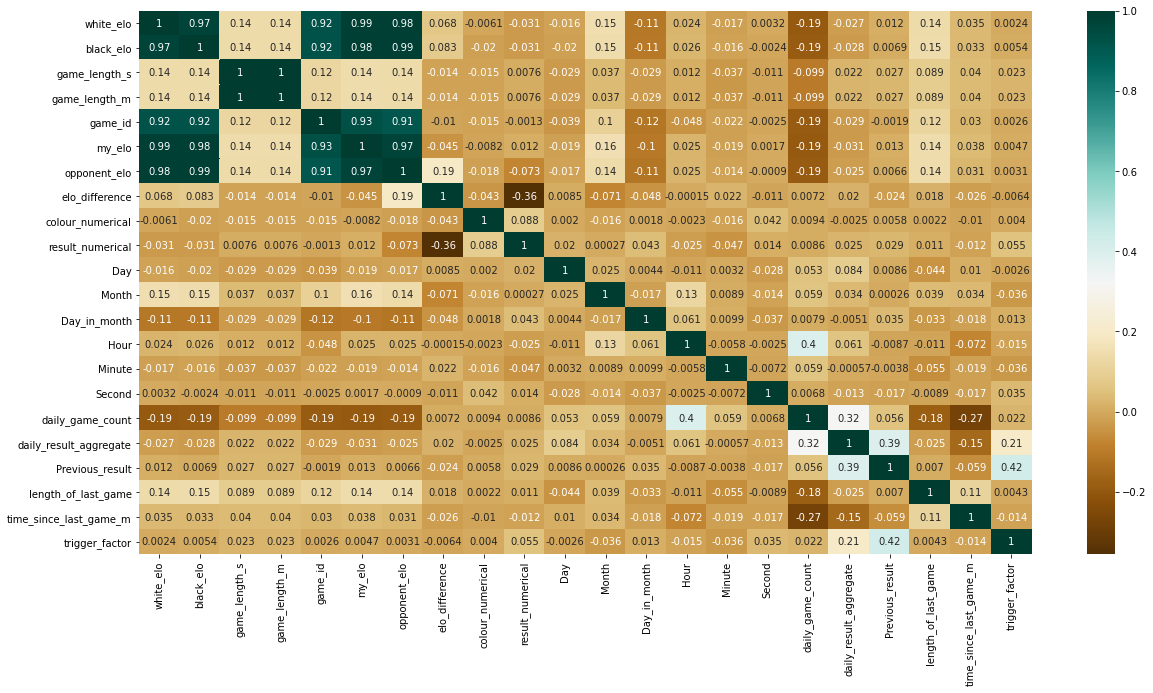

In [1192]:
#correlation heatmap
plt.figure(figsize=(20,10))
c= chess_data.corr()
sns.heatmap(c,cmap="BrBG",annot=True)
c

In [1194]:
chess_data.to_csv(f'chess_data_{person_of_interest}.csv')